In [338]:
ts_files = [
    'vm_1_VmgiCwYcPy.csv',
    'vm_2_rr2y46iWRI.csv',
    'vm_3_Ch2tshNe8X.csv',
    'vm_5_FXoWmAfKug.csv',
    'vm_8_gesjL49nFh.csv',
    'vm_12_aa1PrVE9ie.csv',
    'vm_14_XpTL07_3it.csv',
    'vm_15_PNj1J6v0YJ.csv',
    'vm_17_YDo5PVK_75.csv',
    'vm_19_GF6t1yYrx3.csv',
    'vm_20_N0gBVBQviQ.csv',
    'vm_21_gQI5vMY9+5.csv',
    'vm_22_l93uKkSTv8.csv',
    'vm_23_KxsOjS16uU.csv',
    'vm_25_bImCpIMf2H.csv',
    'vm_26_mY+fWVBQe0.csv'
]

In [339]:
#base_path = '/content/drive/MyDrive/MS/dataset/singlets/'
#data_path = base_path + ts_files[2]

base_path = 'https://raw.githubusercontent.com/gags13/datasets/main/'
data_path = base_path + ts_files[0]

In [340]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

In [341]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [342]:
ts_df = pd.read_csv(data_path, index_col=False, delimiter=',')
ts_df.drop(['Unnamed: 0'],axis=1, inplace=True)
ts_df.head()

,timestamp,vm_id,min_cpu,max_cpu,avg_cpu
0,85200,VmgiCwYcPyuVKNKLhzm6xUxJ4jsMK8T6YG93Pi3zQs/VZ5...,0.219183,0.505346,0.372415
1,85500,VmgiCwYcPyuVKNKLhzm6xUxJ4jsMK8T6YG93Pi3zQs/VZ5...,0.281989,25.755838,4.451139
2,85800,VmgiCwYcPyuVKNKLhzm6xUxJ4jsMK8T6YG93Pi3zQs/VZ5...,0.899012,1.727505,1.293648
3,86100,VmgiCwYcPyuVKNKLhzm6xUxJ4jsMK8T6YG93Pi3zQs/VZ5...,0.859224,97.822844,11.689617
4,86400,VmgiCwYcPyuVKNKLhzm6xUxJ4jsMK8T6YG93Pi3zQs/VZ5...,0.936299,98.129159,10.717084


In [343]:
vm_id = ts_df.vm_id.values[0]
print("VM ID :", vm_id)

VM ID : VmgiCwYcPyuVKNKLhzm6xUxJ4jsMK8T6YG93Pi3zQs/VZ5iahHCByIcloZWJHGSg


In [344]:
ts_df.drop(['vm_id'],axis=1, inplace=True)
ts_df.head()

,timestamp,min_cpu,max_cpu,avg_cpu
0,85200,0.219183,0.505346,0.372415
1,85500,0.281989,25.755838,4.451139
2,85800,0.899012,1.727505,1.293648
3,86100,0.859224,97.822844,11.689617
4,86400,0.936299,98.129159,10.717084


In [345]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, GRU

In [346]:
tf.random.set_seed(1310)

In [347]:
ts_df['timestamp'] = ts_df['timestamp']/300
ts_df['timestamp'] = ts_df['timestamp'].astype('int')
ts_df.head()

,timestamp,min_cpu,max_cpu,avg_cpu
0,284,0.219183,0.505346,0.372415
1,285,0.281989,25.755838,4.451139
2,286,0.899012,1.727505,1.293648
3,287,0.859224,97.822844,11.689617
4,288,0.936299,98.129159,10.717084


In [348]:
def timeseries (x_axis, y_axis, y_label):
    plt.figure(figsize = (20, 6))
    plt.plot(x_axis, y_axis, color ='blue')
    plt.xlabel('time', {'fontsize': 12}) 
    plt.ylabel(y_label, {'fontsize': 12})

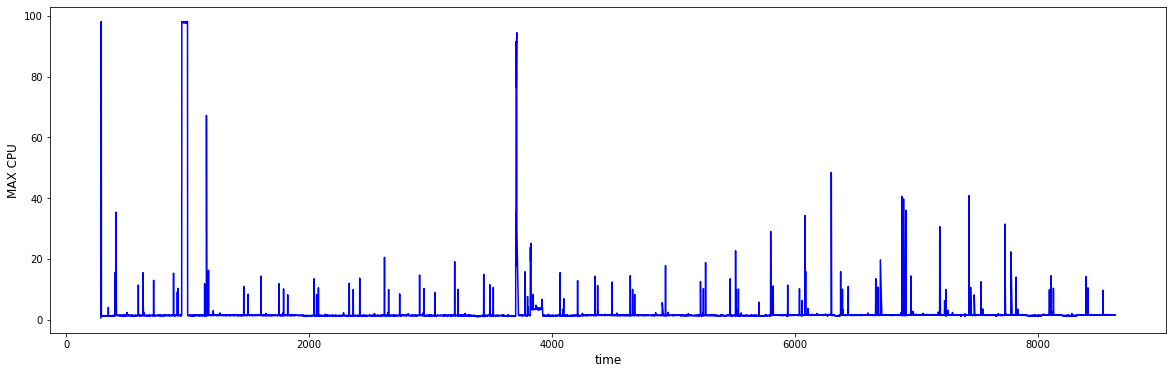

In [349]:
timeseries (ts_df['timestamp'], ts_df['max_cpu'], 'MAX CPU')

In [350]:
df_max = ts_df.drop(['min_cpu', 'avg_cpu'], axis=1)
df_max = df_max.set_index('timestamp')
df_max.head()

,max_cpu
timestamp,
284,0.505346
285,25.755838
286,1.727505
287,97.822844
288,98.129159


In [351]:
# Split train data and test data
train_size = int(len(df_max)*0.7)

train_data = df_max.iloc[:train_size]
test_data = df_max.iloc[train_size:]

In [352]:
test_data.shape

(2474, 1)

In [353]:
def df_input_to_X_y(df, window_size=864):
  df_to_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_to_np)-window_size):
    row = [[a] for a in df_to_np[i:i+window_size]]
    X.append(row)
    label = df_to_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [354]:
WINDOW_SIZE = 864
X_train, y_train = df_input_to_X_y(train_data,WINDOW_SIZE)
X_test, y_test = df_input_to_X_y(test_data,WINDOW_SIZE)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (4907, 864, 1, 1)
y_train.shape:  (4907, 1)
X_test.shape:  (1610, 864, 1, 1)
y_test.shape:  (1610, 1)


In [355]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse', metrics=["mae", "acc"])
    return model
model_gru = create_gru(64)

In [356]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 15,  
                        validation_split = 0.3,
                        batch_size = 8, shuffle = False)
    return history
history_gru = fit_model(model_gru)

Epoch 1/15
430/430 [==============================] - 29s 60ms/step - loss: 18.0106 - mae: 0.6298 - acc: 0.0000e+00 - val_loss: 2.9384 - val_mae: 0.3174 - val_acc: 0.0000e+00
Epoch 2/15
430/430 [==============================] - 24s 56ms/step - loss: 16.3457 - mae: 0.6216 - acc: 0.0000e+00 - val_loss: 2.9945 - val_mae: 0.3269 - val_acc: 0.0000e+00
Epoch 3/15
430/430 [==============================] - 25s 58ms/step - loss: 15.1546 - mae: 0.6083 - acc: 0.0000e+00 - val_loss: 3.0732 - val_mae: 0.3496 - val_acc: 0.0000e+00
Epoch 4/15
430/430 [==============================] - 25s 59ms/step - loss: 14.4223 - mae: 0.6211 - acc: 0.0000e+00 - val_loss: 3.1114 - val_mae: 0.3467 - val_acc: 0.0000e+00
Epoch 5/15
430/430 [==============================] - 25s 57ms/step - loss: 14.0192 - mae: 0.6032 - acc: 0.0000e+00 - val_loss: 3.1403 - val_mae: 0.3327 - val_acc: 0.0000e+00
Epoch 6/15
430/430 [==============================] - 26s 60ms/step - loss: 13.5771 - mae: 0.6000 - acc: 0.0000e+00 - val_los

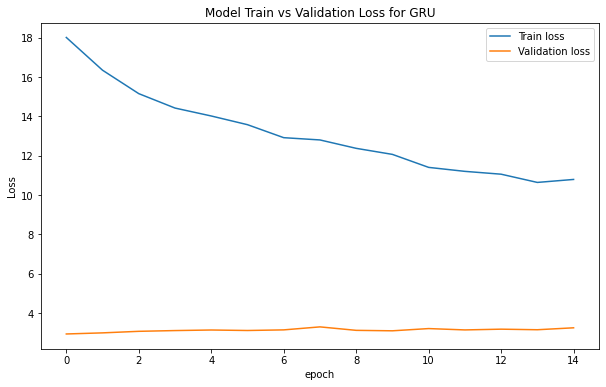

In [357]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')

In [358]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    return prediction
prediction_gru = prediction(model_gru)

51/51 [==============================] - 2s 21ms/step


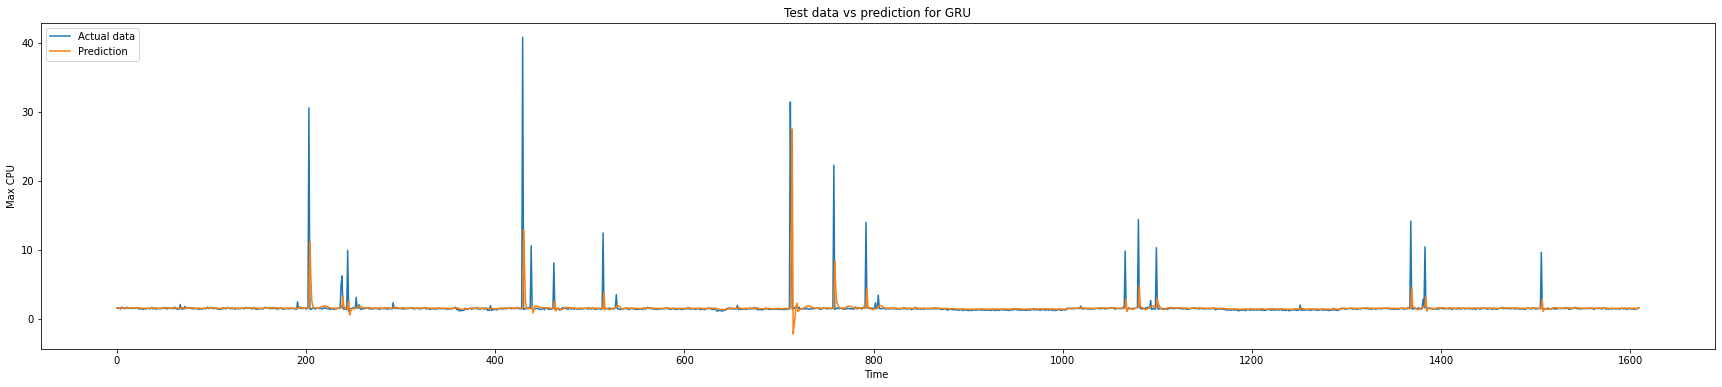

In [359]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(30, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Actual data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time ')
    plt.ylabel('Max CPU')
 
plot_future(prediction_gru, 'GRU', y_test)

In [360]:
predicted_max_list = []
for looped in prediction_gru:
  predicted_max_list.append(looped[0])
len(predicted_max_list)

1610

In [361]:
analysis_df = pd.DataFrame()
analysis_df = test_data.tail(prediction_gru.shape[0])
analysis_df['pred_max_cpu'] = predicted_max_list
analysis_df.shape

(1610, 2)

In [362]:
max_allowed_jump = 1.5
peak_quantile = 0.9
prev_val = analysis_df['pred_max_cpu'].quantile(q=peak_quantile)
i = 0.91
while i < 1:
  curr_val = analysis_df['pred_max_cpu'].quantile(q=i)
  if (curr_val - (prev_val*max_allowed_jump)) > 0.0:
    break
  peak_quantile = i
  prev_val = curr_val
  i = i + 0.01

peak_val = analysis_df['pred_max_cpu'].quantile(q=peak_quantile)
print(peak_val)

2.8419506525993574


In [363]:
analysis_df.insert(0, 'id', range(1, 1 + len(analysis_df)))
analysis_df.head()

,id,max_cpu,pred_max_cpu
timestamp,,,
6988,1,1.552242,1.569982
6989,2,1.555923,1.574475
6990,3,1.496012,1.575972
6991,4,1.491216,1.566863
6992,5,1.414324,1.553231


In [364]:
analysis_df[analysis_df['pred_max_cpu'] > peak_val].id.values

array([ 205,  206,  240,  431,  432,  516,  714,  715,  760,  761,  794,
       1068, 1082, 1101, 1370, 1385, 1508])

In [365]:
high_cpu_values = set(analysis_df[analysis_df['pred_max_cpu'] > peak_val].id.values)
len(high_cpu_values)

17

In [366]:
high_band_cpu = []
for val in high_cpu_values:
  high_band_cpu.extend(list(range(val-5,val+5)))

In [367]:
print(len(high_band_cpu))
print(len(set(high_band_cpu)))

170
134


In [368]:
high_cpu_values = high_cpu_values.union(set(high_band_cpu))
len(high_cpu_values)

134

In [369]:
analysis_df['highcpu'] = analysis_df['id'].map(lambda p : 100 if p in high_cpu_values else 50)
analysis_df[analysis_df['highcpu'] == 100].shape

(134, 4)

Text(0, 0.5, 'Max CPU')

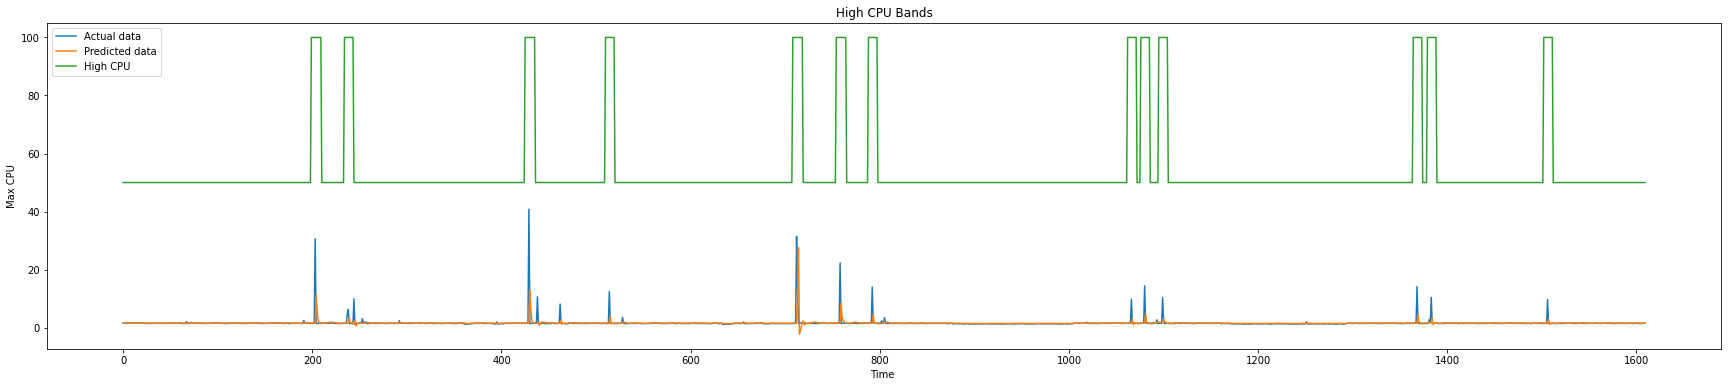

In [370]:
plt.figure(figsize=(30, 6))
range_future = len(analysis_df)
plt.plot(np.arange(range_future), np.array(analysis_df.max_cpu), 
         label='Actual data')
plt.plot(np.arange(range_future), 
         np.array(analysis_df.pred_max_cpu),label='Predicted data')
plt.plot(np.arange(range_future), 
         np.array(analysis_df.highcpu),label='High CPU')
plt.title('High CPU Bands')
plt.legend(loc='upper left')
plt.xlabel('Time ')
plt.ylabel('Max CPU')

In [371]:
data_path = 'https://raw.githubusercontent.com/gags13/datasets/main/final_filtered.csv'

vm_dataframe = pd.read_csv(data_path, index_col=False, delimiter=',')
vm_dataframe.drop(['Unnamed: 0'],axis=1, inplace=True)
vm_dataframe.head()

,vmid,subscriptionid,deploymentid,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,lifetime,corehour,target,delmaxavg,delmaxp95,delp95avg,kmeans,gm,p95avgcpuslope
0,trjCc/lisNnKRnpFtPMmULgw1gUoiymSCshiGZfLY/Oil4...,9j4lLAdcydRsC+LhAQG/IS6Q15Z+tw3IYiCwH6QuxxtuQ1...,amCh31pwRrNqxYhYZMQ9kTaBv6Nsj9KELkMwZXIujmvpbm...,0,2591400,96.715705,0.938933,0.863622,Delay-insensitive,2,2,719.833333,1439.666667,1,95.776771,95.852083,-0.075311,0,1,0.919790
1,RVfel1jVo2UTjdHeqMgqJcVcfBUG/V9mV6Un47p8vGHiFj...,NM+rYlOuvfObftjnvrHy7hUorr5ulWm8UgTM9A1SZniRTv...,tGInpwc5Wi0Tq15xunBKLtsbC6Bxk5LP2e+NIsoDe/D3jg...,0,2589000,98.226568,2.410055,2.297678,Delay-insensitive,2,8,719.166667,1438.333333,1,95.816514,95.928891,-0.112377,0,2,0.953372
2,mY+fWVBQe0tTfdVMO/2Ea9AAjDyN2ndi/40U59iUNxiTRu...,8mYUop47Ih3Ka0m8+fxnNmM1rUjlJ9vDkclgoBJViVmWPr...,fIRf+CYG8jmlnysPUgzCuo7L/D1tV9jirr4FaJCQtaI7/n...,28800,2591400,97.194277,2.076477,1.938042,Delay-insensitive,4,32,711.833333,2847.333333,1,95.117800,95.256236,-0.138435,0,1,0.933332
3,N0gBVBQviQ4n/jyolzXWac39GOcL3596Re7d2N7RpmffGF...,8mYUop47Ih3Ka0m8+fxnNmM1rUjlJ9vDkclgoBJViVmWPr...,fIRf+CYG8jmlnysPUgzCuo7L/D1tV9jirr4FaJCQtaI7/n...,28500,2591400,98.838522,2.479152,2.367730,Delay-insensitive,4,32,711.916667,2847.666667,1,96.359369,96.470792,-0.111423,0,1,0.955056
4,4Cka/a5H763ZPaDuuNo6MhnfKQ56hvTrTxPgWmcJyh2ItB...,HzLK24LbYXd1kU9jw99gYFREpnAkKefq7MKwAxhEwzct60...,wggQWvknTcqrfDqxcQGGT40iu8/aEgjBj5i6e3bu9qtUc8...,0,2591400,99.278745,0.895093,0.716898,Delay-insensitive,2,2,719.833333,1439.666667,1,98.383652,98.561847,-0.178195,0,1,0.800920


In [372]:
core_hour_saved_per_core = (5*len(analysis_df[analysis_df['highcpu'] == 50])/60)/2
total_core_hour_per_core = 5*len(analysis_df)/60
core_count = vm_dataframe[vm_dataframe['vmid'] == vm_id].vmcorecountbucket.values[0]

In [373]:
print("TOTAL CPU CORE HOUR (CURRENT)", total_core_hour_per_core*core_count)
print("TOTAL CPU CORE HOUR (PROPOSED)", (total_core_hour_per_core*core_count) - (core_hour_saved_per_core*core_count))

TOTAL CPU CORE HOUR (CURRENT) 536.6666666666666
TOTAL CPU CORE HOUR (PROPOSED) 290.66666666666663


In [374]:
print("WASTED CPU %",100*(((total_core_hour_per_core*core_count) - (core_hour_saved_per_core*core_count))/(total_core_hour_per_core*core_count)))

WASTED CPU % 54.16149068322981
